In [1]:
import torch
import torch.nn as nn
# import os
import numpy as np
# import math
import os
from torch.autograd import Variable
# from torch.utils.data import Dataset
# import torch.optim as optim 
# import random

# from sklearn.metrics import r2_score, explained_variance_score

# from networks.Network1_v1 import Network1, Network1_Data_loader
# from networks.Network1_v5 import Network1, Network1_Data_loader
# from networks.Network1_v2 import Network1, Network1_Data_loader
# from networks.Network1_v3 import Network1, Network1_Data_loader
from networks.Network1_v31 import Network1, Network1_Data_loader
# from networks.Network3 import Network3, Network3_Data_loader

from matplotlib import pyplot as plt

### Data Preprocessing

In [2]:
def data_extractor(filename, processed_filename1, processed_filename2=None):
    # cleans IMU outputs and generates usable dataset as a clean CSV file
    
    file = open(filename, 'r')
    out_file1 = open(processed_filename1, 'w')
    if processed_filename2 is not None:
        out_file2 = open(processed_filename2, 'w')
    
    start_time, end_time, time  = '', '', ''
    lin_ctr = 0
    
    for l in file:
        if l[0] == '[':                              # if data has timestamp logging on
            time, line = l[10:22], l[24:].rstrip()
        else:
            line = l.rstrip()
            
        tab_ctr = line.count("\t")
        if tab_ctr == 3 or tab_ctr == 9:
            lin_ctr += 1
            line_lst = line.rstrip().split("\t")
            if line_lst[0]=='LSM_raw: ' :
                print(line.rstrip(), file=out_file2, end=";\t\t")
            elif line_lst[0]=='MPU_raw: ' :
                print(line.rstrip(), file=out_file1, end=";\t\t")
            elif line_lst[0]=='MPU_ypr: ' :
                print(line.rstrip(), file=out_file1, end="\n")
                print(line.rstrip(), file=out_file2, end="\n")
            if lin_ctr == 1 :
                start_time = time
            #elif line_lst[0]=='LSM_ypr: ' :
            #    print(line.rstrip(), file=out_file1, end="\n")
    
    end_time = time
    print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file1, end="\n")
    
    if processed_filename2 is not None:
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file2, end="\n")
        out_file2.close()
        
    out_file1.close()
    file.close()
    
def file_train_test_splitter(input_file_name, train_percent):
    # splits the input file into two files given by the train_percent
        # example usage : file_train_test_splitter("input.txt", 70)
    
    with open(input_file_name, 'r') as f:
        for i, l in enumerate(f):
            pass
    lines_in_file = i + 1   # total number of lines, aka, data points in the input file
    f.close()
    
    try:
        ratio = train_percent / 100
    except:
        print("Error: Invalid train test split ratio")
    
    num_train_data_points = int(lines_in_file * ratio)
    num_test_data_points = lines_in_file - num_train_data_points
    
    train_out_file = open(os.path.splitext(input_file_name)[0]+"_train_data.csv", 'w')
    test_out_file = open(os.path.splitext(input_file_name)[0]+"_test_data.csv", 'w')
    
    line_ctr = 0
    with open(input_file_name, 'r') as f:
        for line in f:
            line_ctr += 1
            line = line.rstrip()
            if line_ctr <= num_train_data_points:
                print(line, file = train_out_file)
            else:
                print(line, file = test_out_file)
    
    f.close()
    test_out_file.close()
    train_out_file.close()
    
    print("Train and test files created.")

In [3]:
# Data Pre-processing 

# data_extractor("Datasets/MPU_rawtoypr_11.csv", "Datasets/MPU_rawtoypr_11_cleaned.csv")
# file_train_test_splitter("Datasets/MPU_rawtoypr_11_cleaned.csv", 70)

trial_num = 2

data_extractor("Datasets/rawtoypr_{}.csv".format(trial_num), 
               "Datasets/MPU_rawtoypr_{}_cleaned.csv".format(trial_num), 
               "Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num))

file_train_test_splitter("Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num), 70)

Train and test files created.


### Deep Learning Network

In [4]:
# model = Network1(init_weights=True)
model = Network1(init_weights=True)
print(model)

Network1(
  (fc_y1): Linear(in_features=9, out_features=8)
  (fc_y2): Linear(in_features=8, out_features=7)
  (fc_y3): Linear(in_features=7, out_features=5)
  (fc_y4): Linear(in_features=5, out_features=3)
  (fc_y5): Linear(in_features=3, out_features=1)
  (fc_p1): Linear(in_features=9, out_features=8)
  (fc_p2): Linear(in_features=8, out_features=7)
  (fc_p3): Linear(in_features=7, out_features=5)
  (fc_p4): Linear(in_features=5, out_features=3)
  (fc_p5): Linear(in_features=3, out_features=1)
  (fc_r1): Linear(in_features=9, out_features=8)
  (fc_r2): Linear(in_features=8, out_features=7)
  (fc_r3): Linear(in_features=7, out_features=5)
  (fc_r4): Linear(in_features=5, out_features=3)
  (fc_r5): Linear(in_features=3, out_features=1)
  (relu): ReLU(inplace)
)


#### Initialize model weights from older checkpoint (if necessary)

In [5]:
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v5_network_state_checkpoint80.pth")
state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1/network_state_checkpoint25.pth")
model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/Sensor_fusion/saved_model_weights/Net1_v3.1/network_state_checkpoint25.pth 
...onto the CPU. 



### Instantiating the Data Loader class

In [6]:
# training data LSM raw -> LSM ypr
data_train = Network1_Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned_train_data.csv".format(trial_num) )    
data_test = Network1_Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned_test_data.csv".format(trial_num) ) 

# yaw_dset_train_lpf98 = Data_loader("Datasets/360_yaw_lpf_98_data_cleaned.txt")     # training data LSM raw -> MPU ypr   
#yaw_dset_mpu_lpf98   = Data_loader("Datasets/mpu_360_yaw_lpf_98_data_cleaned.txt") # testing data MPU raw -> MPU ypr

In [7]:
print("Total training data samples = ", len(data_train))
print("Training Data matrix shape = ",data_train.data_matrix.shape)

print("Total test data samples = ", len(data_test))
print("Test Data matrix shape = ",data_test.data_matrix.shape)

Total training data samples =  2751
Training Data matrix shape =  (2751, 12)
Total test data samples =  1178
Test Data matrix shape =  (1178, 12)


#### Some pre training / testing initializations . . .

In [8]:
# Initializing the DataLoader(s)
dsets_enqueuer_training = torch.utils.data.DataLoader(data_train, batch_size=1, 
                                                      num_workers=1, drop_last=False)
dsets_enqueuer_testing = torch.utils.data.DataLoader(data_test, batch_size=1, 
                                                      num_workers=1, drop_last=False)

epochs = 200

### Training / Testing the network

In [ ]:
loss_lst_train, loss_lst_test, r_sq_lst, r_sq_lst_test,  var_exp_lst, var_exp_lst_test = model.train_model(epochs, 
                                                                                               dsets_enqueuer_training, 
                                                                                               dsets_enqueuer_testing)




[ Training Network ]

Epoch 	1 / 200 , 	 loss = [[3.3395565 1.6810292 1.3137184]] , 	 R^2 = -21.9451 , 	 Var exp = -793.0919 %
Epoch 	2 / 200 , 	 loss = [[3.1832001 1.3838362 0.807651 ]] , 	 R^2 = -19.125 , 	 Var exp = -854.4479 %
Epoch 	3 / 200 , 	 loss = [[3.1460726 1.184135  0.6252276]] , 	 R^2 = -18.095 , 	 Var exp = -817.0923 %
Epoch 	4 / 200 , 	 loss = [[3.109131  1.044134  0.5525848]] , 	 R^2 = -17.3622 , 	 Var exp = -788.1286 %
Epoch 	5 / 200 , 	 loss = [[3.0754735  0.97856396 0.5184649 ]] , 	 R^2 = -16.9134 , 	 Var exp = -784.0859 %
Epoch 	6 / 200 , 	 loss = [[3.033359   0.93296957 0.49231467]] , 	 R^2 = -16.5196 , 	 Var exp = -769.9494 %
Epoch 	7 / 200 , 	 loss = [[2.990696   0.8893861  0.47170174]] , 	 R^2 = -16.1788 , 	 Var exp = -765.3738 %
Epoch 	8 / 200 , 	 loss = [[2.9562461  0.8494426  0.45328256]] , 	 R^2 = -15.8759 , 	 Var exp = -760.9046 %
Epoch 	9 / 200 , 	 loss = [[2.9318998  0.81674755 0.43802205]] , 	 R^2 = -15.6892 , 	 Var exp = -767.0328 %
Epoch 	10 / 200 ,

Epoch 	77 / 200 , 	 loss = [[0.3533019  0.31376705 0.35031974]] , 	 R^2 = -4.9358 , 	 Var exp = -464.7486 %
Epoch 	78 / 200 , 	 loss = [[0.34943536 0.31316358 0.35007986]] , 	 R^2 = -4.9129 , 	 Var exp = -462.4848 %
Epoch 	79 / 200 , 	 loss = [[0.34656218 0.3123594  0.34989184]] , 	 R^2 = -4.8953 , 	 Var exp = -461.2309 %
Epoch 	80 / 200 , 	 loss = [[0.3441307  0.31185588 0.3496865 ]] , 	 R^2 = -4.8792 , 	 Var exp = -459.7894 %
Epoch 	81 / 200 , 	 loss = [[0.3412884  0.31107244 0.34950453]] , 	 R^2 = -4.8659 , 	 Var exp = -458.1484 %
Epoch 	82 / 200 , 	 loss = [[0.3387169 0.3104377 0.3492883]] , 	 R^2 = -4.8493 , 	 Var exp = -456.8676 %
Epoch 	83 / 200 , 	 loss = [[0.33580866 0.30976722 0.34906718]] , 	 R^2 = -4.8352 , 	 Var exp = -455.1292 %
Epoch 	84 / 200 , 	 loss = [[0.33328944 0.30907032 0.3488392 ]] , 	 R^2 = -4.818 , 	 Var exp = -453.5815 %
Epoch 	85 / 200 , 	 loss = [[0.3302566  0.30849373 0.34860224]] , 	 R^2 = -4.8005 , 	 Var exp = -451.9106 %
Epoch 	86 / 200 , 	 loss = [[0.3

Epoch 	153 / 200 , 	 loss = [[0.27244934 0.26249644 0.33782262]] , 	 R^2 = -4.5622 , 	 Var exp = -429.32 %
Epoch 	154 / 200 , 	 loss = [[0.27217674 0.26208675 0.33773842]] , 	 R^2 = -4.5507 , 	 Var exp = -428.1053 %
Epoch 	155 / 200 , 	 loss = [[0.2719013  0.2613927  0.33750236]] , 	 R^2 = -4.5562 , 	 Var exp = -428.8242 %
Epoch 	156 / 200 , 	 loss = [[0.27170318 0.26090506 0.33733487]] , 	 R^2 = -4.5492 , 	 Var exp = -428.3252 %
Epoch 	157 / 200 , 	 loss = [[0.2715337  0.2603695  0.33721966]] , 	 R^2 = -4.5507 , 	 Var exp = -428.5072 %
Epoch 	158 / 200 , 	 loss = [[0.27109388 0.25996712 0.33699554]] , 	 R^2 = -4.5442 , 	 Var exp = -427.7488 %


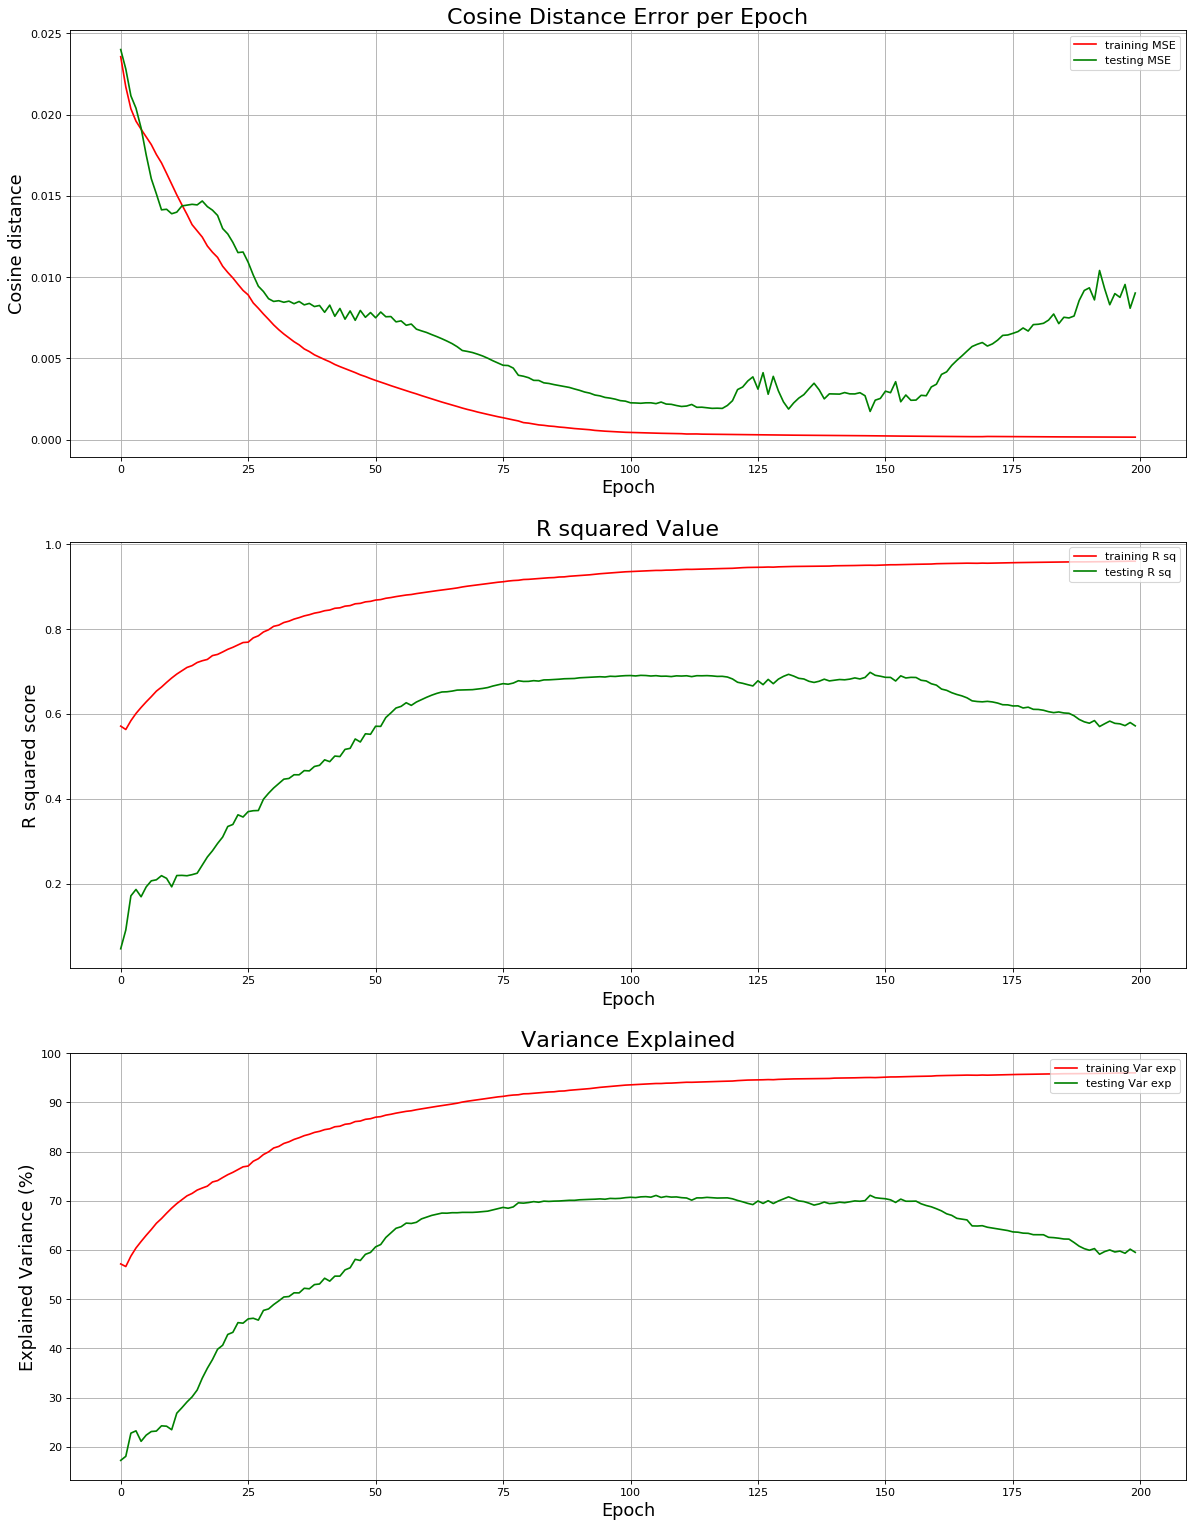

In [10]:
train_loss = np.squeeze(np.mean(np.array(loss_lst_train), axis=2))
test_loss = np.squeeze(np.mean(np.array(loss_lst_test), axis=2))

plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=80)

plt.subplot(311)
plt.title('Cosine Distance Error per Epoch', fontsize=20)
plt.plot( train_loss , 'r')            # this is the mean squared error among yaw, pitch, roll angles
plt.plot( test_loss  , 'g')            # can have a max value of 360^2 = 126000
# plt.plot( np.array(loss_lst_train) , 'r')            # this is the mean squared error among yaw, pitch, roll angles
# plt.plot( np.array(loss_lst_test)  , 'g')
plt.ylabel("Cosine distance", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training MSE', 'testing MSE'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title("R squared Value", fontsize=20)
plt.plot(r_sq_lst, 'r')
plt.plot(r_sq_lst_test, 'g')
plt.ylabel("R squared score", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training R sq', 'testing R sq'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title("Variance Explained", fontsize=20)
plt.plot(np.array(var_exp_lst) * 100, 'r')
plt.plot(np.array(var_exp_lst_test) * 100, 'g')
plt.ylabel("Explained Variance (%)", fontsize=16)
# plt.ylim(-100,110)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training Var exp', 'testing Var exp'], loc='upper right')
plt.grid()

plt.show()

### Loading Network weights that have the best testing loss

In [12]:
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v5_network_state_checkpoint80.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v3_network_state_checkpoint95.pth")
state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth")

model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/Sensor_fusion/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth 
...onto the CPU. 



In [13]:
data_test2 = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned_test_data.csv", sequential_test_mode=True)
dsets_enqueuer_trial = torch.utils.data.DataLoader(data_test2, batch_size=1, 
                                                      num_workers=1, drop_last=False)

y_lst = []
o_lst = []
data_ctr = 0

for idx, data in enumerate(dsets_enqueuer_trial, 1):
        x,y = data['x'], data['y']
        
        #print(x.shape)
        #print(y.shape)
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = False).float(), Variable(y.cuda(), requires_grad = False).float()
        else:
            x, y = Variable(x, requires_grad = False).float(), Variable(y, requires_grad = False).float()

        model.eval()
        output = model(x)
        
        #print(output.shape)
        
        y_lst.append(y)
        o_lst.append(output)
        data_ctr += 1
        if data_ctr >= 5000:
            break
        
# print("Model output \t= {} \ny \t\t= {}".format(np.squeeze(output.data.numpy()), 
#                                          np.squeeze(y.data.numpy())))
    

In [14]:
# model_output = np.squeeze(np.array(o_lst) )
model_output = np.squeeze(np.array(o_lst))
expected = np.squeeze(np.array(y_lst))

pitch_out, pitch_exp     = model_output[:,0], expected[:,0]
roll_out, roll_exp = model_output[:,1], expected[:,1]
yaw_out, yaw_exp   = model_output[:,2], expected[:,2]

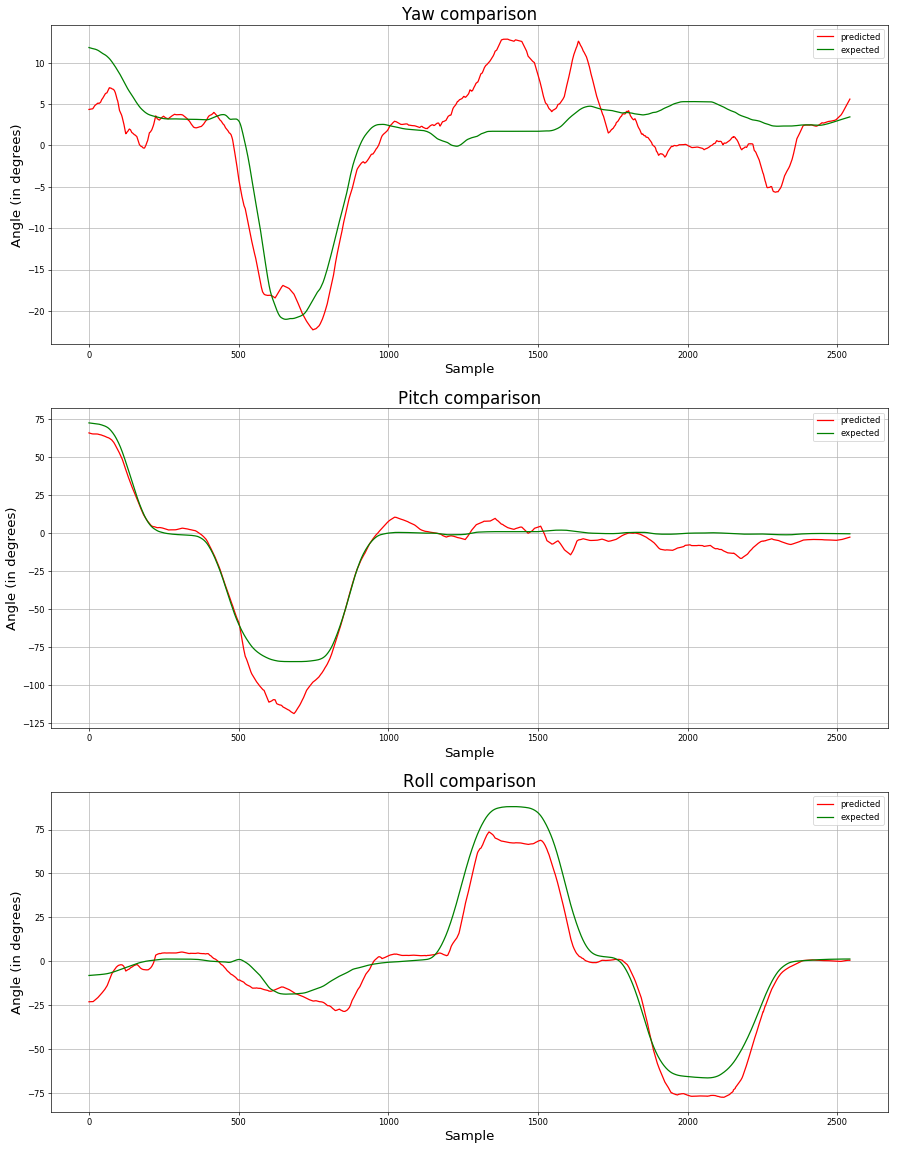

In [15]:
plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=60)

plt.subplot(311)
plt.title('Yaw comparison', fontsize=20)
# plt.plot( yaw_out , 'r')            # model output
plt.plot(np.convolve(yaw_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( yaw_exp  , 'g')            # expected output
plt.plot(np.convolve(yaw_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title('Pitch comparison', fontsize=20)
# plt.plot( pitch_out , 'r')            # model output
plt.plot(np.convolve(pitch_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( pitch_exp  , 'g')            # expected output
plt.plot(np.convolve(pitch_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title('Roll comparison', fontsize=20)
# plt.plot( roll_out , 'r')            # model output
plt.plot(np.convolve(roll_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( roll_exp  , 'g')            # expected output
plt.plot(np.convolve(roll_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.show()

In [16]:
data_test3 = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned.csv", sequential_test_mode=True)
dsets_enqueuer_trial = torch.utils.data.DataLoader(data_test3, batch_size=1, 
                                                      num_workers=1, drop_last=False)

y_lst = []
o_lst = []

for idx, data in enumerate(dsets_enqueuer_trial, 1):
        x,y = data['x'], data['y']
        
        #print(x.shape)
        #print(y.shape)
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = False).float(), Variable(y.cuda(), requires_grad = False).float()
        else:
            x, y = Variable(x, requires_grad = False).float(), Variable(y, requires_grad = False).float()

        model.eval()
        output = model(x)
        
        #print(output.shape)
        
        y_lst.append(y)
        o_lst.append(output)

model_output = np.squeeze(np.array(o_lst))
expected = np.squeeze(np.array(y_lst))

pitch_out, pitch_exp     = model_output[:,0], expected[:,0]
roll_out, roll_exp = model_output[:,1], expected[:,1]
yaw_out, yaw_exp   = model_output[:,2], expected[:,2]

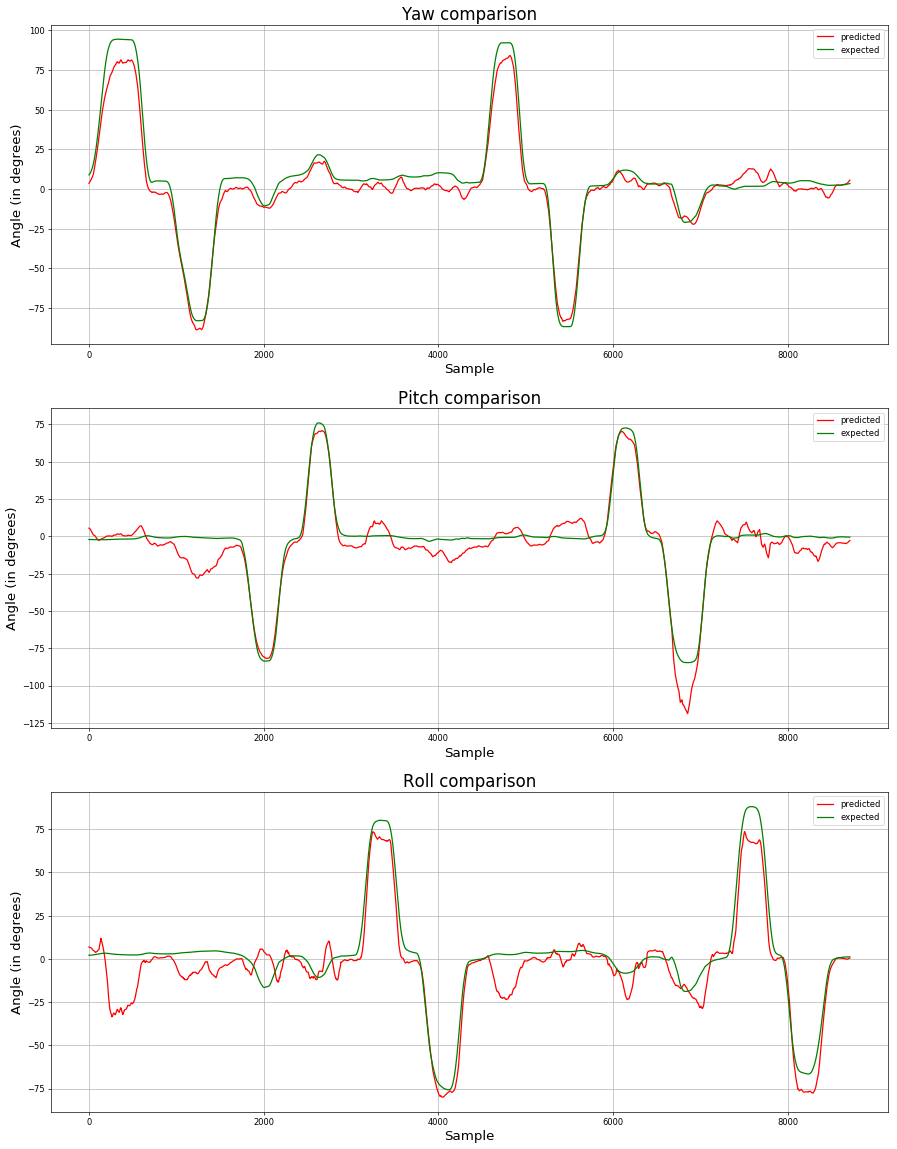

In [17]:
plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=60)

plt.subplot(311)
plt.title('Yaw comparison', fontsize=20)
# plt.plot( yaw_out , 'r')            # model output
plt.plot(np.convolve(yaw_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( yaw_exp  , 'g')            # expected output
plt.plot(np.convolve(yaw_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title('Pitch comparison', fontsize=20)
# plt.plot( pitch_out , 'r')            # model output
plt.plot(np.convolve(pitch_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( pitch_exp  , 'g')            # expected output
plt.plot(np.convolve(pitch_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title('Roll comparison', fontsize=20)
# plt.plot( roll_out , 'r')            # model output
plt.plot(np.convolve(roll_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( roll_exp  , 'g')            # expected output
plt.plot(np.convolve(roll_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.show()

In [ ]:
~